In [1]:
# Importing required libraries
import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import MobileNetV3Large  # Importing MobileNetV3Large model for transfer learning
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr  # Importing Gradio for creating interactive web interfaces for machine learning models

In [2]:
# Defining dataset directory
dataset_dir= r"/Users/amanjavelin/Documents/AICTE Shell/TrashType_Image_Dataset"
image_size = (224, 224)
batch_size = 32
seed = 42

In [3]:
# Train Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.25,
    subset="training",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)
train_class=train_ds.class_names

Found 2527 files belonging to 6 classes.
Using 1896 files for training.


In [4]:
# Validation Dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.25,
    subset="validation",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)
val_class= val_ds.class_names

Found 2527 files belonging to 6 classes.
Using 631 files for validation.


In [5]:
# Getting the total number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)  

# Splitting the validation dataset into two equal parts:
# First half becomes the test dataset
test_ds = val_ds.take(val_batches // 2)  
# Second half remains as the validation dataset
val_dat = val_ds.skip(val_batches // 2)  

# Optimizing test dataset by caching and prefetching to improve performance
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)  

In [6]:
# Printing class details
print(train_class)
print(val_class)
print(len(train_class))

['Cardboard', 'Glass', 'Metal', 'Paper', 'Plastic', 'Trash']
['Cardboard', 'Glass', 'Metal', 'Paper', 'Plastic', 'Trash']
6


2025-07-03 20:04:17.718810: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


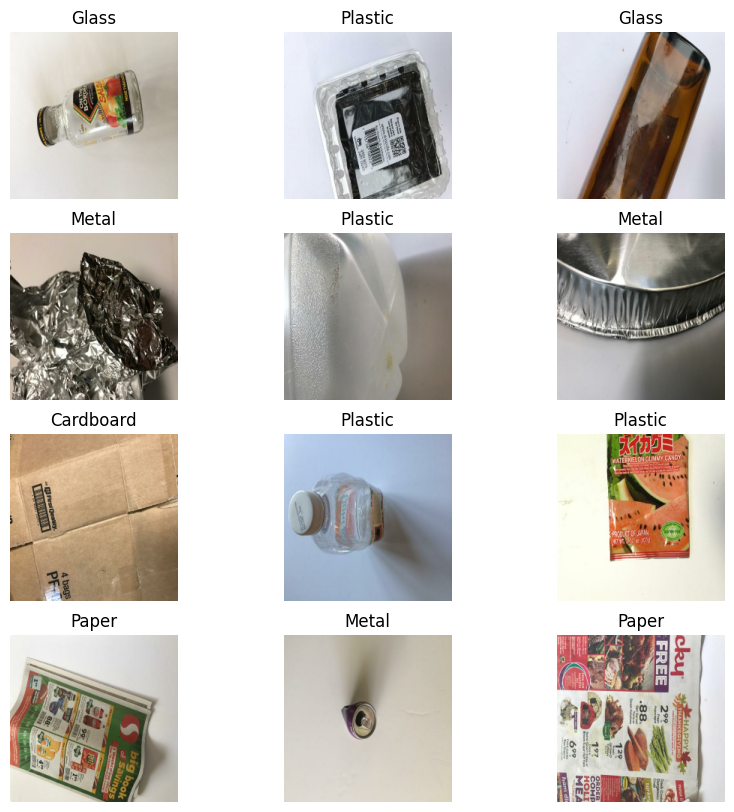

In [7]:
# Sample images from each class
plt.figure(figsize=(10, 10))
for images, labels in train_ds.repeat(1).take(1):
    for i in range(12):  
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")      

In [8]:
# Function to calculate the class distribution
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}
    dataset=dataset.repeat(1)
    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  
    return counts

In [9]:
# Function to plot class distribution
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

In [10]:
# Getting class distributions
class_names = train_ds.class_names
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)

print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)

{'Cardboard': 16.77, 'Glass': 19.73, 'Metal': 15.51, 'Paper': 23.52, 'Plastic': 19.36, 'Trash': 5.12}
{'Cardboard': 13.47, 'Glass': 20.13, 'Metal': 18.38, 'Paper': 23.45, 'Plastic': 18.23, 'Trash': 6.34}
{'Cardboard': 14.69, 'Glass': 20.31, 'Metal': 19.38, 'Paper': 22.81, 'Plastic': 16.56, 'Trash': 6.25}
{'Cardboard': 15.12, 'Glass': 19.93, 'Metal': 16.95, 'Paper': 23.48, 'Plastic': 18.8, 'Trash': 5.73}


2025-07-03 20:04:18.160732: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-03 20:04:18.286024: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


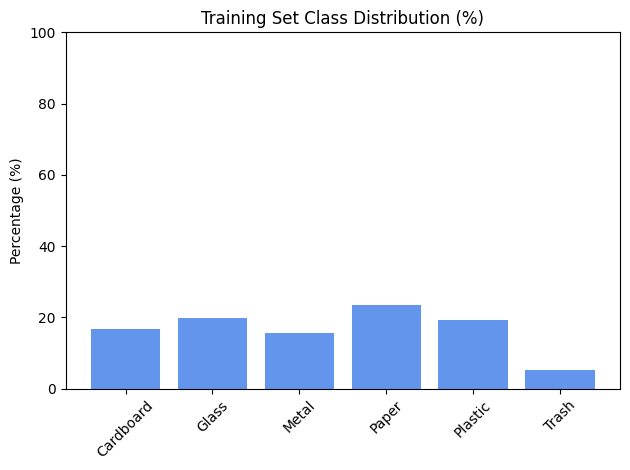

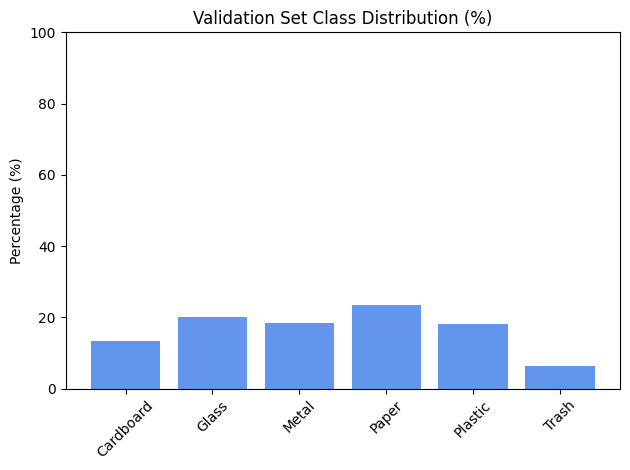

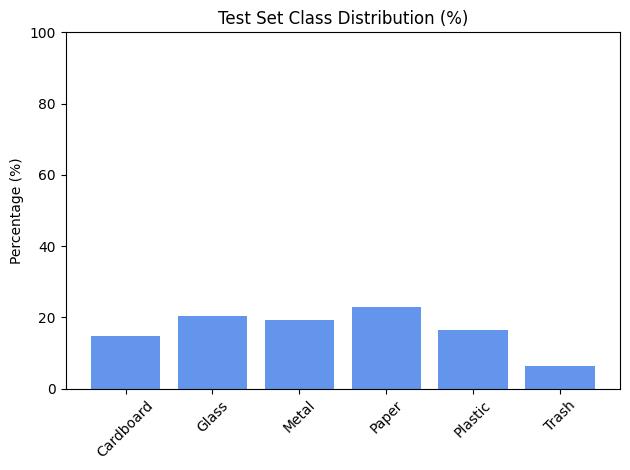

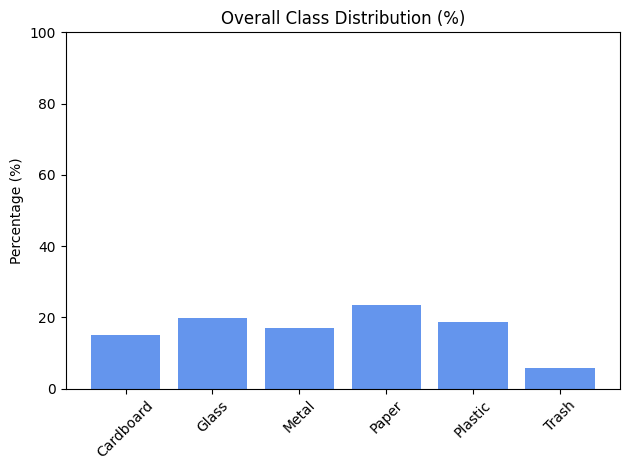

In [11]:
# Showing visualizations for class distribution
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

In [12]:
# Counting class occurrences to prepare label list
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

# Computing class weights (index aligned)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

# Creating dictionary mapping class index to weight
class_weights = {i: float(w) for i, w in enumerate(class_weights_array)}

In [13]:
# Printing results
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)

Class Counts: {0: 318, 1: 374, 2: 294, 3: 446, 4: 367, 5: 97}
Class Weights: {0: 0.9937106918238994, 1: 0.8449197860962567, 2: 1.0748299319727892, 3: 0.7085201793721974, 4: 0.8610354223433242, 5: 3.2577319587628866}


In [14]:
# Defining data augmentation pipeline
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [15]:
# Loading the pretrained MobileNetV3Large model 
base_model = MobileNetV3Large(include_top=False, input_shape=(224, 224, 3),include_preprocessing=True, weights='imagenet')

# Freezing early layers (to retain general pretrained features)
base_model.trainable = True
for layer in base_model.layers[:100]:  
    layer.trainable = False

In [16]:
# Building the final model
model = Sequential([
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  
])

In [17]:
# Compiling the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
# Defining an EarlyStopping callback to stop training when validation loss stops improving
early = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=2)
]

In [19]:
# Setting the number of epochs to train the model
epochs = 15 

# Training the model using the fit function
history1 = model.fit(
    train_ds,                     
    validation_data=val_ds,      
    epochs=epochs,                
    class_weight=class_weights,   
    batch_size=32,                
    callbacks=[early]             
)

# Unfreezing entire base model
base_model.trainable = True  
print("Unfreezing all layers for fine-tuning...")

# Re-compiling with lower learning rate
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Continuing training
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights,  
    batch_size=32,               
    callbacks=[early]
)

Epoch 1/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 25s 357ms/step - accuracy: 0.3029 - loss: 1.8335 - val_accuracy: 0.5832 - val_loss: 1.0939 - learning_rate: 1.0000e-04
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 356ms/step - accuracy: 0.6742 - loss: 0.9950 - val_accuracy: 0.6926 - val_loss: 0.8044 - learning_rate: 1.0000e-04
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 22s 372ms/step - accuracy: 0.7913 - loss: 0.6116 - val_accuracy: 0.7433 - val_loss: 0.6673 - learning_rate: 1.0000e-04
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 24s 398ms/step - accuracy: 0.8605 - loss: 0.4163 - val_accuracy: 0.7655 - val_loss: 0.5969 - learning_rate: 1.0000e-04
Epoch 5/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 447ms/step - accuracy: 0.9067 - loss: 0.2914 - val_accuracy: 0.8098 - val_loss: 0.5029 - learning_rate: 1.0000e-04
Epoch 6/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 30s 503ms/step - accuracy: 0.9286 - loss: 0.2162 - val_accuracy: 0.8368 - val_loss: 0.4253 - learning_rate: 1.0000e-04
Epoch 7/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 34s 567ms/step - acc

In [20]:
# Summary 
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         5,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,637,652 (32.95 MB)

 Trainable params: 2,817,766 (10.75 MB)

 Non-trainable params: 184,352 (720.12 KB)

 Optimizer params: 5,635,534 (21.50 MB)

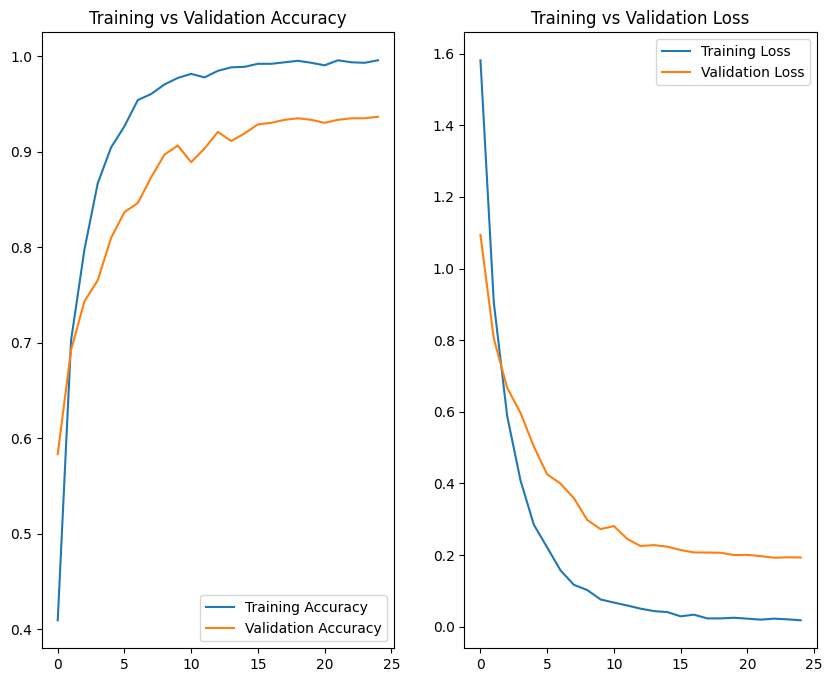

In [21]:
# Model Performance visualizations
acc = history1.history['accuracy'] + history2.history['accuracy']
val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
loss = history1.history['loss'] + history2.history['loss']
val_loss = history1.history['val_loss'] + history2.history['val_loss']

epochs_range = range(len(acc))    

plt.figure(figsize=(10,8))      

# Creating first subplot (1 row, 2 columns, position 1)
plt.subplot(1,2,1)                         
plt.plot(epochs_range, acc, label='Training Accuracy')       
plt.plot(epochs_range, val_acc, label='Validation Accuracy') 
plt.legend(loc='lower right')                                
plt.title('Training vs Validation Accuracy')                 

# Creating second subplot (1 row, 2 columns, position 2)
plt.subplot(1,2,2)                         
plt.plot(epochs_range, loss, label='Training Loss')         
plt.plot(epochs_range, val_loss, label='Validation Loss')  
plt.legend(loc='upper right')                              
plt.title('Training vs Validation Loss')                    
plt.show()                              

In [22]:
# Summary
loss, accuracy = model.evaluate(test_ds_eval)
print(f'Test accuracy is {accuracy:.4f}, Test loss is {loss:.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - accuracy: 0.9586 - loss: 0.1330
Test accuracy is 0.9438, Test loss is 0.1682


In [23]:
# Extracting true labels from all batches in the test dataset
y_true = np.concatenate([y.numpy() for x, y in test_ds_eval], axis=0)  

# Getting predictions as probabilities from the model
y_pred_probs = model.predict(test_ds_eval)                             

# Converting probabilities to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)                               

# Computing the confusion matrix to evaluate classification performance
cm = confusion_matrix(y_true, y_pred)  

# Printing metrics to assess model performance
print(cm)  
print(classification_report(y_true, y_pred))  

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step
[[40  0  0  1  0  0]
 [ 0 64  2  0  2  0]
 [ 0  3 58  0  0  1]
 [ 0  0  1 74  0  0]
 [ 0  3  1  0 52  1]
 [ 0  0  1  2  0 14]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        41
           1       0.91      0.94      0.93        68
           2       0.92      0.94      0.93        62
           3       0.96      0.99      0.97        75
           4       0.96      0.91      0.94        57
           5       0.88      0.82      0.85        17

    accuracy                           0.94       320
   macro avg       0.94      0.93      0.93       320
weighted avg       0.94      0.94      0.94       320



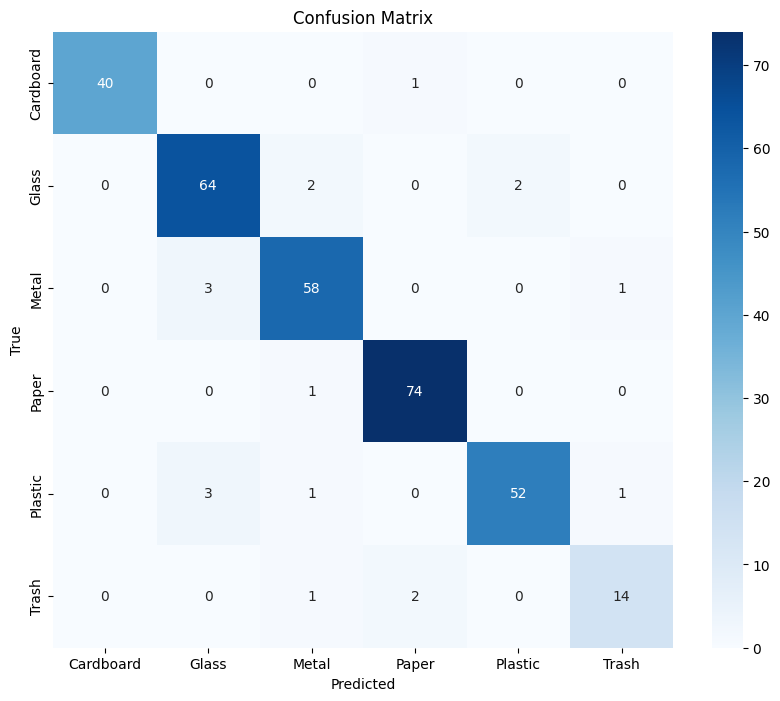

In [24]:
# Setting figure size for better visualization
plt.figure(figsize=(10,8))  #

sns.heatmap(cm, annot=True, fmt='d',  
            xticklabels=class_names,  
            yticklabels=class_names,  
            cmap='Blues')  

plt.xlabel('Predicted')  
plt.ylabel('True')  
plt.title('Confusion Matrix')  
plt.show() 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


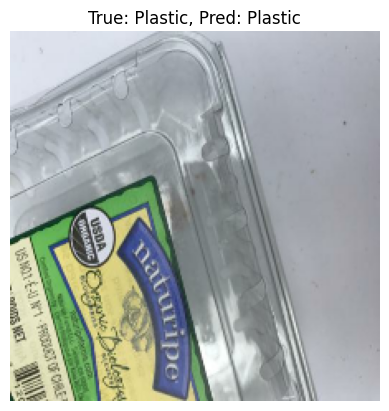

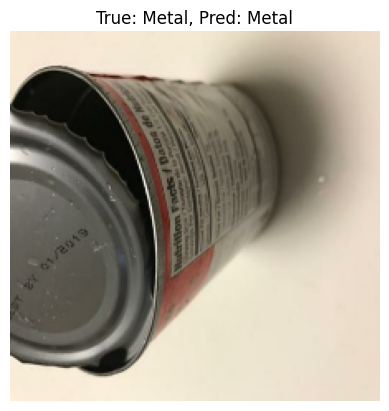

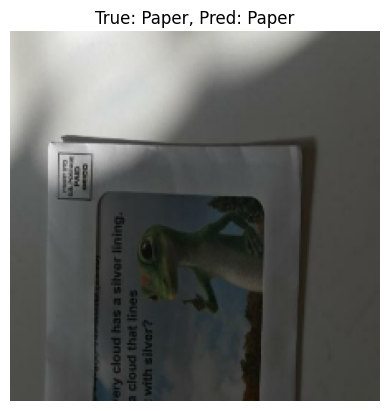

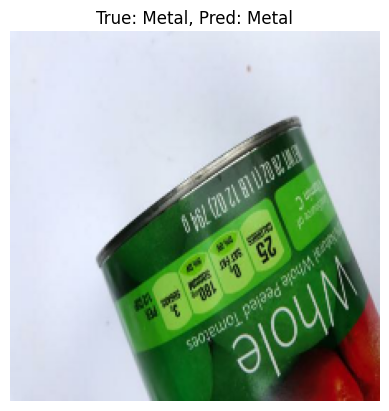

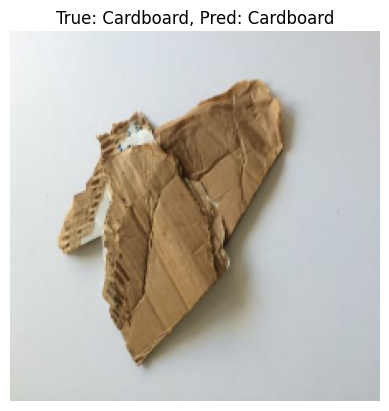

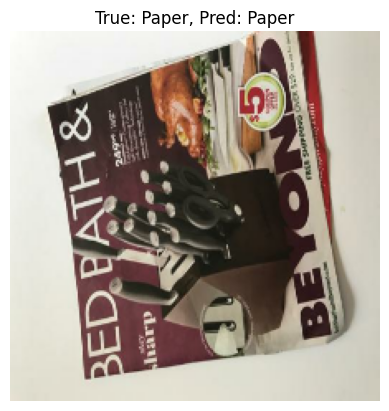

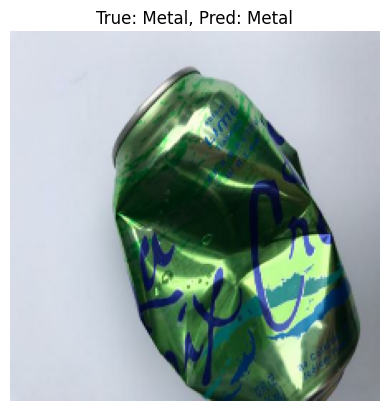

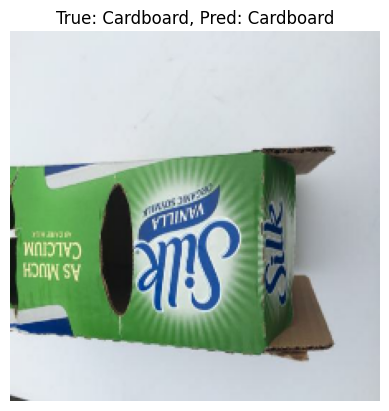

In [25]:
# Extracting class names from the training dataset
class_names = train_ds.class_names  

# Taking one batch of images and labels from the test dataset for evaluation
for images, labels in test_ds_eval.take(1):  

    # Generating predictions for the batch of images
    predictions = model.predict(images)  

    # Getting the predicted class index for each image
    pred_labels = tf.argmax(predictions, axis=1)  

    # Looping through the first 8 images in the batch
    for i in range(8):  
        plt.imshow(images[i].numpy().astype("uint8"))  
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  
        plt.axis("off")  
        plt.show()  

In [26]:
# Saving model in Keras format with architecture, weights, and training configuration
model.save('MobileNetV3Large.keras')

# Loading the Keras model
model = tf.keras.models.load_model('MobileNetV3Large.keras')